<h1 align="center">PNICER demonstration notebook</h1> 


In [2]:
# First we define some file paths to point to PNICER and its test files
pnicer_path = "/Users/Antares/Dropbox/Projects/PNICER/"
test_resources_path = pnicer_path + "tests_resources/"
science_path = test_resources_path + "Orion_A_2mass.fits"
control_path = test_resources_path + "CF_2mass.fits"

## Import stuff

**PNICER** main dependencies are *numpy* and *scikit-learn*. In addition also *matplotlib*, *astropy*, and *wcsaxes* are required for extended functionality

In [3]:
# Insert PNICER directory into system path for import
import sys
import numpy as np

from astropy.io import fits

if pnicer_path not in sys.path:
    sys.path.insert(0, pnicer_path)
from pnicer import Magnitudes
%matplotlib inline

## Define file paths and load data

The implementation requires the data to be parsed in lists of arrays. Here we load magnitudes and errors for both the science and the controlf field.

In [4]:
# ----------------------------------------------------------------------
# Define feature names and extinction vector
features_names = ["Jmag", "Hmag", "Kmag"]
errors_names = ["e_Jmag", "e_Hmag", "e_Kmag"]
features_extinction = [2.5, 1.55, 1.0]


# ----------------------------------------------------------------------
# Load data
with fits.open(science_path) as science, fits.open(control_path) as control:

    science_dummy = science[1].data
    control_dummy = control[1].data

    # Coordinates
    science_glon, control_glon = science_dummy["GLON"], control_dummy["GLON"]
    science_glat, control_glat = science_dummy["GLAT"], control_dummy["GLAT"]

    # Photometry
    science_data = [science_dummy[n] for n in features_names]
    control_data = [control_dummy[n] for n in features_names]

    # Errors
    science_error = [science_dummy[n] for n in errors_names]
    control_error = [control_dummy[n] for n in errors_names]

## Initialize data

The **PNICER** implementation includes both the new probabilistic approach as well as **NICER**. The data can be initialzed as a *Magnitude* instance. Alternativley also a *Colors* instance can be used. A *Colors* instance can also be created from a *Magnitudes* instance which calculates consecutive colors for the input data.

For the initialization we need the coordinates, photometry, and errors, as well as the extinction vector defined above. Alternativley, we can also specify feature names.

In [5]:
science = Magnitudes(mag=science_data, err=science_error, extvec=features_extinction,
                     lon=science_glon, lat=science_glat, names=features_names)
control = Magnitudes(mag=control_data, err=control_error, extvec=features_extinction,
                     lon=control_glon, lat=control_glat, names=features_names)

Or now in colors:

In [6]:
science_color = science.mag2color()
control_color = control.mag2color()

## Plot stuff

**PNICER** also includes a set of plot methods, which help to visualize the data. One, for instance, may first like to look at the density distribution in the feature combinations:

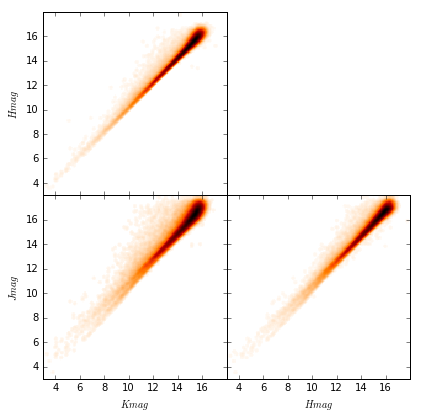

In [7]:
science.plot_combinations_kde()

We can do the same plot in color space with the instances created before:

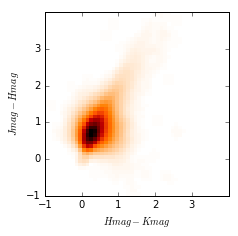

In [8]:
science.mag2color().plot_combinations_kde()

Also, it is very useful to look at the spatial distribution of sources. With the following plotting method we can display a kernel density map of all input features.

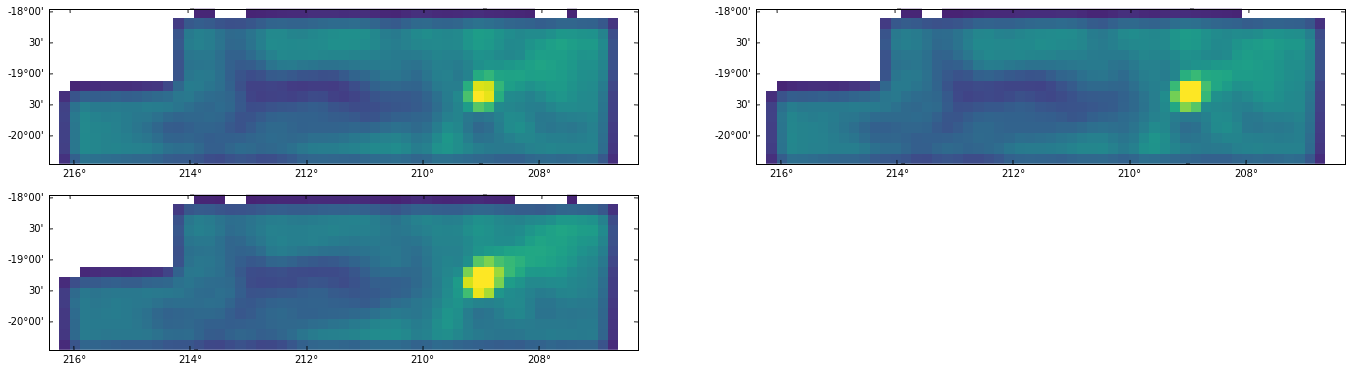

In [9]:
science.plot_spatial_kde(frame="galactic", pixsize=10/60)

## Running the software

Now that we had a look at our data, it is time to calculate color-excesses. The software packages offers both the new **PNICER** method, as well as a **NICER** implementation. Let's run both:

In [10]:
ext_pnicer = science.pnicer(control=control, sampling=2, add_colors=True)
ext_nicer = science.nicer(control=control)

We must note a few things here:

+ **NICER** can only be run with a *Magnitudes* instance, since the individual photometrc errors are used
+ **PNICER** can run on both *Magnitudes* and *Colors* instances as long as you know the extinction vector for the components
+ **PNICER** has an option to also include consecutive colors on top of magnitudes. Above, the *add_colors* option adds all colors from the input photometry to the **PNICER** calculation. This can be advantageous since stars and galaxies exhibit distinct infrared colors, whereas magnitudes also depend on distance when no extinction is involved. This option expands the parameter space, and depending on the sample size and the number of features, can significantly increase computation time.

Both calculations return and *Extinction* instance from which further options are available. We can save the data in a FITS table if we want:

In [11]:
ext_pnicer.save_fits(path="/tmp/temp.fits")

Or we can directly access the extinction for each source

In [12]:
ext_pnicer.extinction

array([ 0.00891824,  0.53215339,  0.1239372 , ..., -0.01754672,
        0.3560886 ,  0.15787892])

Also, we can access the calculated intrinsic properties for each source

In [13]:
ext_pnicer.intrinsic

[array([ 0.6073279 ,  0.50092209,  0.22804614, ...,  0.49301767,
         0.41749168,  0.49571931]),
 array([ 0.04076119,  0.22606965,  0.24077582, ...,  0.11646674,
         0.17076668,  0.19100769])]

## Extinction map

The *Extinction* instance we got above can now also be used to calcualte and extinction map. For this, various options are available

In [26]:
pnicer_emap = ext_pnicer.build_map(bandwidth=5 / 60, metric="gaussian", frame="galactic",
                                   sampling=2, nicest=False, use_fwhm=True)

nicer_emap = ext_pnicer.build_map(bandwidth=5 / 60, metric="gaussian", frame="galactic",
                                  sampling=2, nicest=False, use_fwhm=True)

The methods above return an *ExtinctionMap* instance, which again can be used vor some things. We can, for instance, directly access the data:

In [27]:
pnicer_emap.map

This, of course, is a quite bad exmaple because the edges all contain NaNs since no data was available there.
Further, we can save the data as a FITS image:

In [28]:
pnicer_emap.save_fits(path="/tmp/temp.fits")

, and also display the results with a convenient function:

In [29]:
pnicer_emap.plot_map(figsize=10)

These are the basics of **PNICER/NICER**. Happy hunting for extinction! :)